# Fairness & Explainability in Click Prediction Models using the FairJob Dataset

This notebook presents a complete machine learning pipeline for analyzing, training, and explaining a binary classification model using the **FairJob dataset**. The goal is to predict whether a user will click on a job offer, while ensuring **fairness** and **model interpretability**.

## Workflow Overview

1. **Data Loading & Preprocessing**  
   - The FairJob dataset is loaded via HuggingFace and saved locally as a CSV file.
   - All data splits (train, validation, test) are merged into a single DataFrame.
   - Basic statistics and distributions are explored.

2. **Balancing the Dataset**  
   - Since the `click` label is imbalanced, a balanced subset is created by downsampling the majority class.
   - This step ensures fair and unbiased model training.

3. **Model Training**  
   - Two classification models are trained: a Random Forest and an XGBoost classifier.
   - Performance is evaluated using metrics like Accuracy, ROC-AUC, Confusion Matrix, and Classification Report.

4. **Feature Importance & Explainability**
   - **SHAP** and **LIME** are used to understand feature importance and model behavior.
   - SHAP provides both global and local explanations.
   - LIME offers local interpretability for individual predictions.

5. **Explanation Validation**
   - Several explainability metrics are computed:
     - **MEMC Score** (Model Explanation via Masking Consistency)
     - **Infidelity** and **Sensitivity**
     - **Monotonicity Check**
     - **SHAP vs. LIME Agreement** via Spearman correlation
   - These help validate whether the explanations are consistent, robust, and trustworthy.

6. **Visualization & Analysis**
   - Heatmaps, histograms, SHAP summary plots, and bar plots illustrate key feature relationships.
   - A calibration curve visualizes the reliability of the predicted click probabilities.

## Objective

This project combines **traditional machine learning** with modern **explainability** and **fairness analysis** techniques to better understand and validate model decisions. It is particularly relevant for use cases like job recommendation systems, where transparency and ethical decision-making are crucial.


## Preparing and Visualizing the Data

Before jumping into any modeling, it's important to take a step back and get a feel for the dataset.  
In this section, we load the data, clean it if needed, and visualize some key features to understand:

- What kind of data we're working with
- Whether it's balanced or not
- How different variables are distributed

This helps us avoid mistakes later and build better models.


In [1]:
#%pip install datasets
import os
import pandas as pd
from datasets import load_dataset

os.makedirs('data', exist_ok=True)

# Load the Fairjob Dataset
ds = load_dataset("criteo/FairJob")

# The Dataset has different splits (train, validation, test)
# I therefore combine the splits in one DataFrame
all_data = []

for split_name in ds.keys():
    print(f"Processed Split: {split_name}")
    split_data = ds[split_name].to_pandas()
    # I am adding a column with the split_name
    split_data['split'] = split_name
    all_data.append(split_data)
combined_df = pd.concat(all_data, ignore_index=True)

# Saving it as a CSV in the data file
output_path = 'data/fairjob.csv'
combined_df.to_csv(output_path, index=False, encoding='utf-8')

print(f"Training data was succesfully saved in: {output_path}")
print(f"Nr. Rows: {len(combined_df)}")
print(f"Nr. Columns: {len(combined_df.columns)}")
print("Columns:")
for col in combined_df.columns:
    print(f" - {col}")


Processed Split: train
Training data was succesfully saved in: data/fairjob.csv
Nr. Rows: 1072226
Nr. Columns: 57
Columns:
 - click
 - protected_attribute
 - senior
 - displayrandom
 - rank
 - user_id
 - impression_id
 - product_id
 - cat0
 - cat1
 - cat2
 - cat3
 - cat4
 - cat5
 - cat6
 - cat7
 - cat8
 - cat9
 - cat10
 - cat11
 - cat12
 - num16
 - num17
 - num18
 - num19
 - num20
 - num21
 - num22
 - num23
 - num24
 - num25
 - num26
 - num27
 - num28
 - num29
 - num30
 - num31
 - num32
 - num33
 - num34
 - num35
 - num36
 - num37
 - num38
 - num39
 - num40
 - num41
 - num42
 - num43
 - num44
 - num45
 - num46
 - num47
 - num48
 - num49
 - num50
 - split


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/fairjob.csv')
print("Information on the dataset:")

# First I want to compute the distribution
click_counts = df['click'].value_counts()
click_percent = df['click'].value_counts(normalize=True) * 100

# Then I create a table 
summary_table = pd.DataFrame({
    'Click': click_counts.index,
    'Count': click_counts.values,
    'Percentage (%)': click_percent.values.round(2)
})
from IPython.display import display
display(summary_table)



Information on the dataset:


Click    Count  Percentage (%)
0      0  1064737            99.3
1      1     7489             0.7

## Creating a balance 

As the data set is very inbalanced, I will select a subset of the data, choosing as many 'No Ad Clicks' (0) as we have 'Ad clicks' (1)

Choosen Samples from group 0: 7489
✅ Balanced Dataset Overview:


Click  Count  Percentage (%)
0      1   7489            50.0
1      0   7489            50.0


Balanced Dataset is now saved under: data/fairjob_balanced.csv

Comparison:
Datareduction of: 98.6% der ursprünglichen Daten entfernt

DISTRIBUTION CHECK (first few categorical columns)
✅ Pseudo-categorical columns detected: ['protected_attribute', 'senior', 'displayrandom', 'cat0', 'cat1']


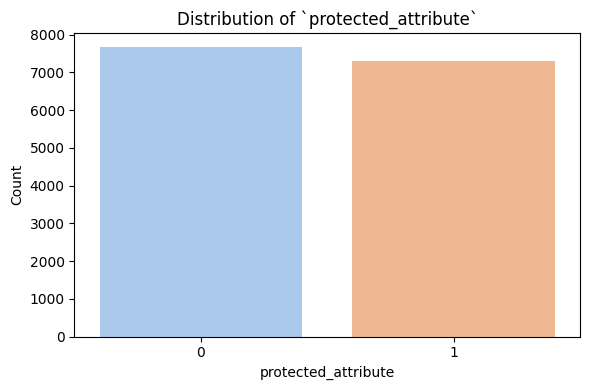

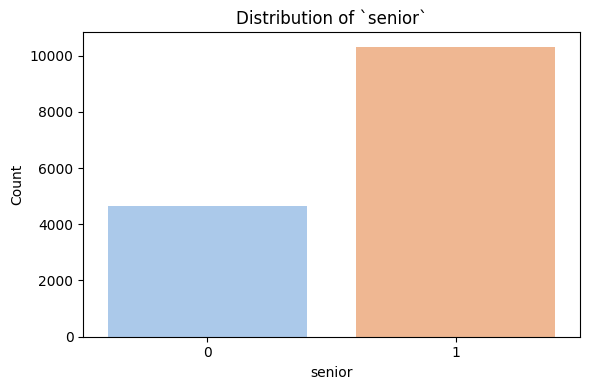

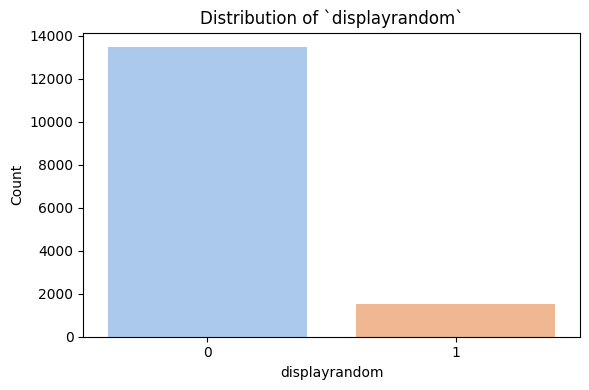

In [3]:

#Creating a balanced Dataset

# 1. Create 2 groups depending on click value
group_0_clicks = df[df['click'] == 0].copy()  # Did not Click on Ad
group_1_clicks = df[df['click'] == 1].copy()  # Clicked on Ad

# 2. Choose as many from group 0 as there are in group 1
n_positive_samples = len(group_1_clicks)
# Random sampling with fixed seed for reproducibility
np.random.seed(42)
group_0_sampled = group_0_clicks.sample(n=n_positive_samples, random_state=42)

print(f"Choosen Samples from group 0: {len(group_0_sampled)}")

# Now I will combine the 2 datasets to create a balanced dataset. Then I will shuffle them.
balanced_df = pd.concat([group_0_sampled, group_1_clicks], ignore_index=True)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Create a summary table for the balanced dataset
click_counts = balanced_df['click'].value_counts()
click_percent = balanced_df['click'].value_counts(normalize=True) * 100

summary_table = pd.DataFrame({
    'Click': click_counts.index,
    'Count': click_counts.values,
    'Percentage (%)': click_percent.values.round(2)
})

from IPython.display import display
print("✅ Balanced Dataset Overview:")
display(summary_table)

#Save balanced Dataset as a csv
output_path = 'data/fairjob_balanced.csv'
balanced_df.to_csv(output_path, index=False, encoding='utf-8')
print(f"\nBalanced Dataset is now saved under: {output_path}")

# Now I will show the difference between the set now and before
print(f"\n{'='*50}")
print("Comparison:")

print(f"Datareduction of: {(1 - len(balanced_df)/len(df))*100:.1f}% der ursprünglichen Daten entfernt")

from IPython.display import display, Markdown

print("\n" + "="*50)
print("DISTRIBUTION CHECK (first few categorical columns)")
print("="*50)

from IPython.display import display, Markdown

# Detecting whether there are low-cardinality integer columns (likely categoricals)
low_card_cols = [
    col for col in balanced_df.select_dtypes(include=['int64', 'int32']).columns
    if balanced_df[col].nunique() <= 10 and col != 'click'
]

print("✅ Pseudo-categorical columns detected:", low_card_cols)

import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the pseudo-categorical columns
for col in low_card_cols[:3]:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=balanced_df, hue=col, palette='pastel', legend=False)
    plt.title(f"Distribution of `{col}`")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

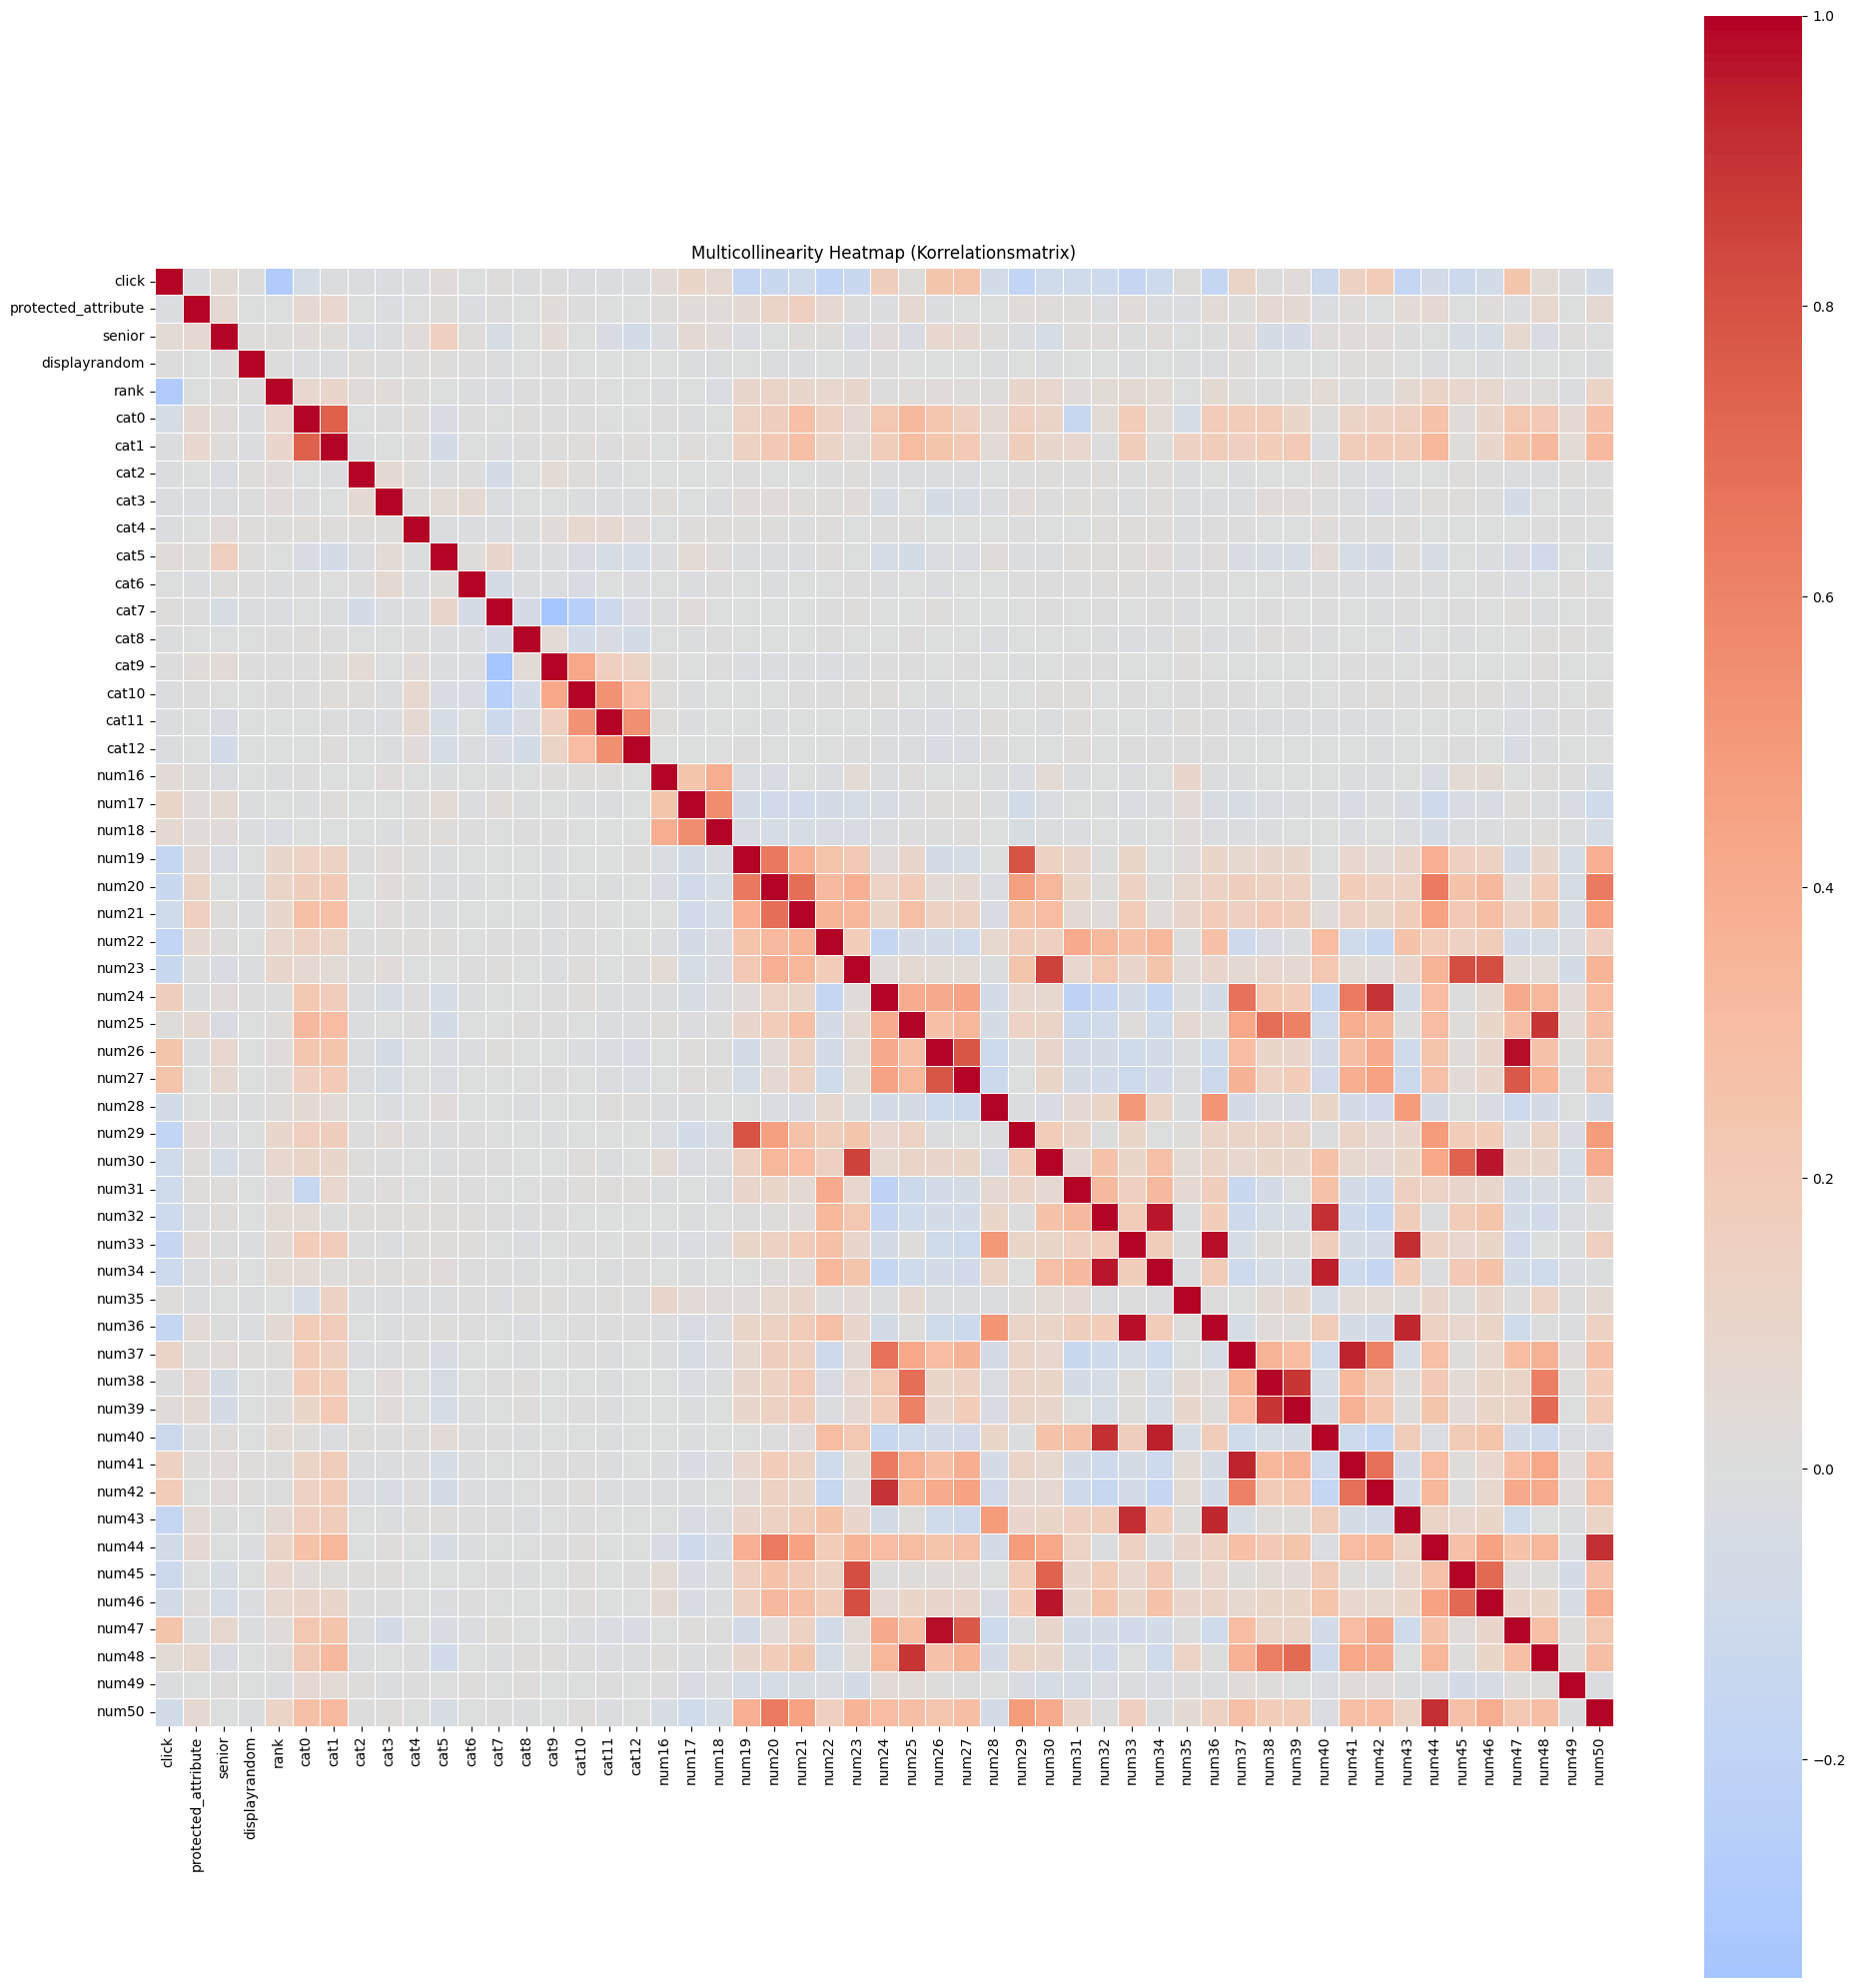

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the balanced dataset
df = pd.read_csv("data/fairjob_balanced.csv")

# Then I remove unnecessary ID Columns
df = df.drop(columns=['user_id', 'product_id', 'impression_id'], errors='ignore')

#Now I want to generate a heatmap warning me which features have a strong correlation
numeric_df = df.select_dtypes(include=['number', 'bool'])
corr_matrix = numeric_df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title("Multicollinearity Heatmap (Korrelationsmatrix)")
plt.tight_layout()
plt.show()


## Correlation Heatmap – Key Findings

- Most features show weak or no correlation with each other.
- No strong signs of multicollinearity were found.
- A few mild clusters (e.g., among categorical or numeric feature groups) exist but do not require action.
- We can proceed to modeling without removing or combining features due to redundancy.


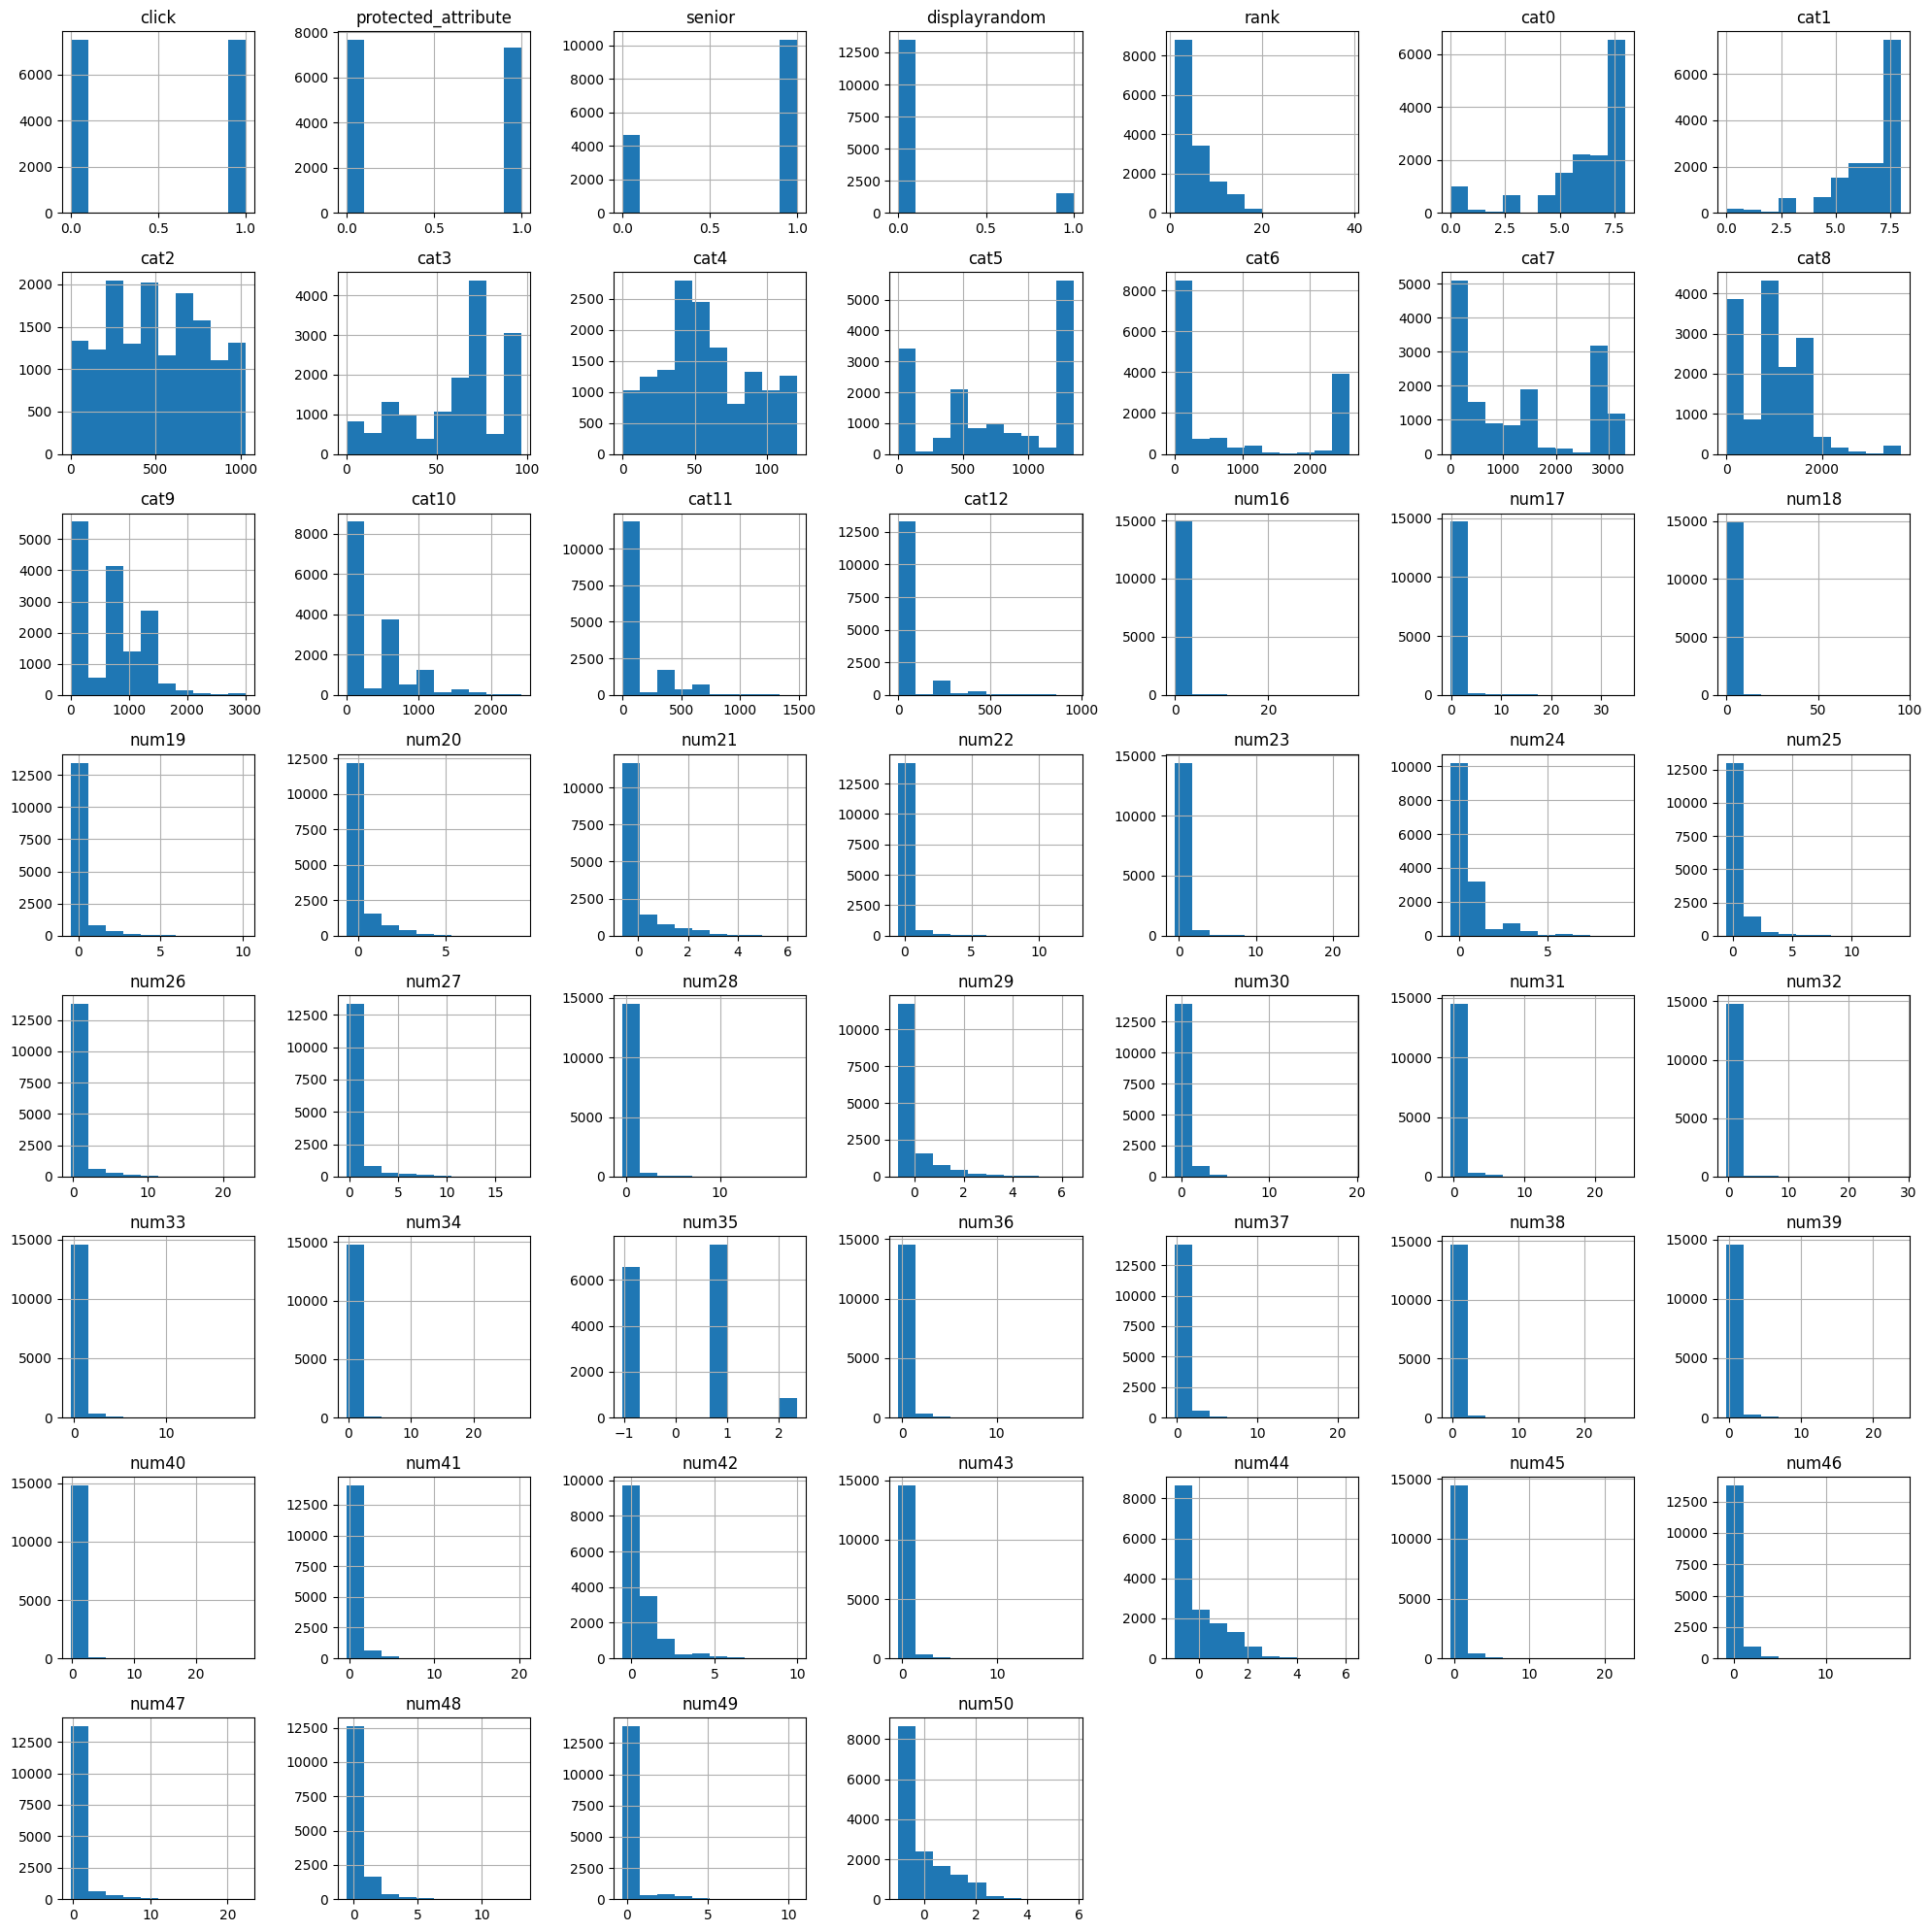

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# In Order to understand the features better I will create Histograms for all numeric and 
# Boolean features.
numeric_df.hist(figsize=(20, 20))
plt.tight_layout()
plt.show()

## Univariate Feature Distributions

To understand the structure of each feature in our dataset, we plotted histograms for all numerical and boolean columns.

**Key Takeaways:**
- Binary features (`click`, `protected_attribute`, etc.) behave as expected.
- Most numeric features are right-skewed, suggesting the need for scaling or transformation.
- Some variables (e.g., `rank`, `catX`) appear categorical, even though they're numeric.
- A few features show outliers or long tails that may impact model performance.

This step helps guide preprocessing decisions before training our models.


## Training a Random Forest Classifier

Now that our data is prepared and balanced, we can train a **Random Forest** model to predict whether a user will click on a job offer.

Random Forest is an ensemble learning method that builds multiple decision trees and combines their results for better performance and robustness.


📊 Confusion Matrix:
[[1152  346]
 [ 345 1153]]

📄 Classification Report:
              precision    recall  f1-score   support

           0     0.7695    0.7690    0.7693      1498
           1     0.7692    0.7697    0.7694      1498

    accuracy                         0.7694      2996
   macro avg     0.7694    0.7694    0.7694      2996
weighted avg     0.7694    0.7694    0.7694      2996

🎯 ROC-AUC Score: 0.8432562954433236
✅ Accuracy: 0.7693591455273698


/tmp/ipykernel_17173/3897619239.py:62: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from current font.
  plt.tight_layout()
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


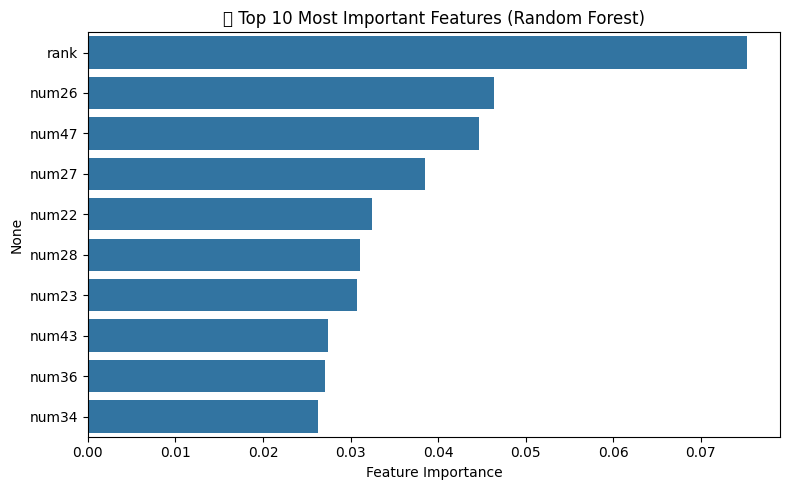

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define features and target
y = df['click']
X = df.drop(columns=['click'])

# Detect numerical columns with low unique values (like CatX and Rank) → treat as categorical
low_cardinality_cols = [
    col for col in X.select_dtypes(include=['int64', 'int32']).columns
    if X[col].nunique() <= 10
]

# Convert those columns to category
for col in low_cardinality_cols:
    X[col] = X[col].astype('category')

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize and train Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    class_weight=None  # Not needed as it is an already balanced dataset
)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

# Evaluation
print("📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("🎯 ROC-AUC Score:", roc_auc_score(y_test, y_proba))
print("✅ Accuracy:", accuracy_score(y_test, y_pred))

# Feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=top_features, y=top_features.index)
plt.title("🔝 Top 10 Most Important Features (Random Forest)")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()


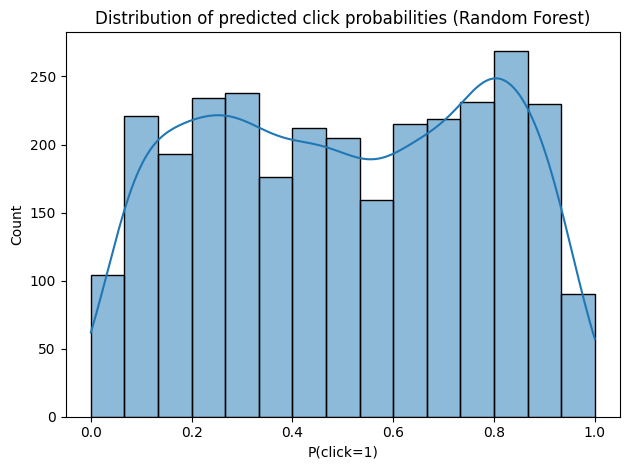

In [7]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# 📊 Vorhersagewahrscheinlichkeiten berechnen (für Klasse 1 = Klick)
proba_rf = rf.predict_proba(X_test)[:, 1]

# 📈 Verteilung plotten
sns.histplot(proba_rf, kde=True)
plt.title("Distribution of predicted click probabilities (Random Forest)")
plt.xlabel("P(click=1)")
plt.tight_layout()
plt.show()


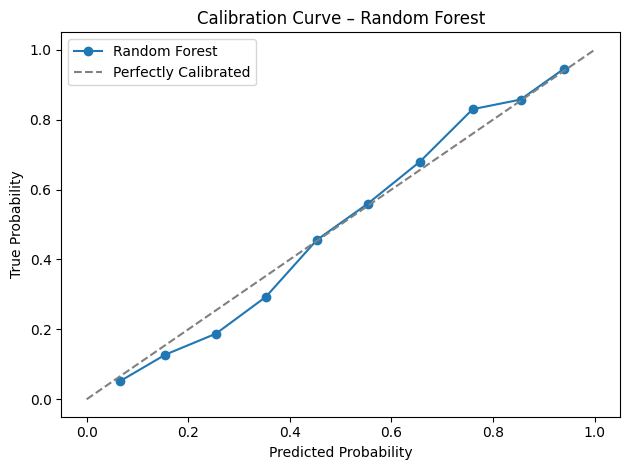

In [8]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
#Now I want to calculate the calibration curve
prob_true_rf, prob_pred_rf = calibration_curve(y_test, proba_rf, n_bins=10)

# 📈 Plot
plt.plot(prob_pred_rf, prob_true_rf, marker='o', label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve – Random Forest")
plt.legend()
plt.tight_layout()
plt.show()


## Shap Analysis of Random Forest

/tmp/ipykernel_17173/3942712314.py:34: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(rf_shap_values, X_rf_sample)


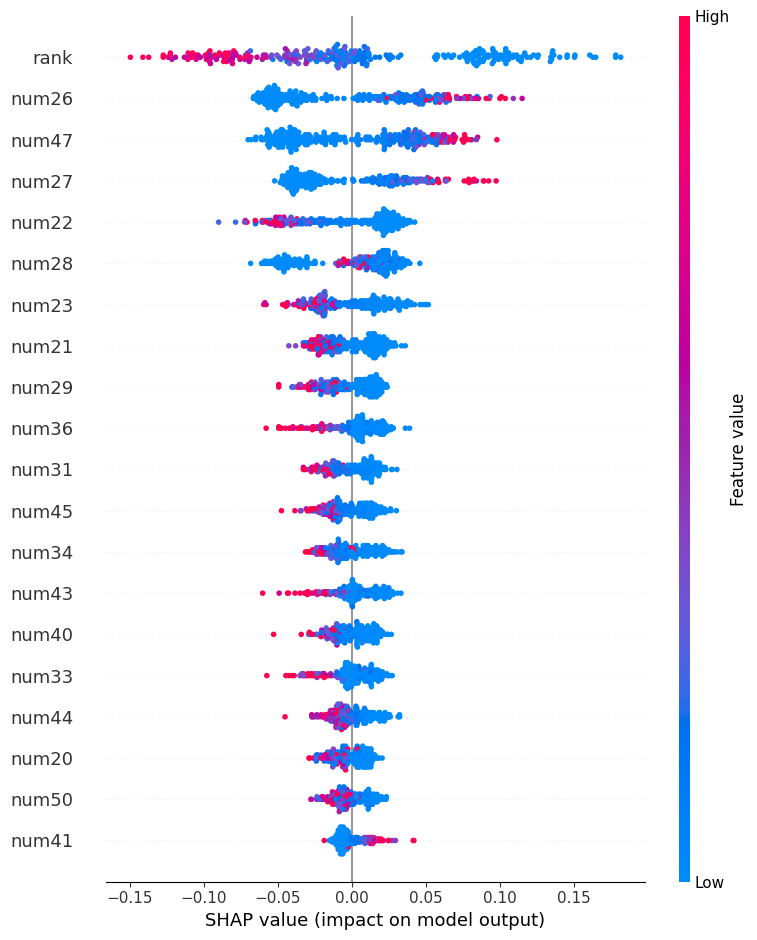

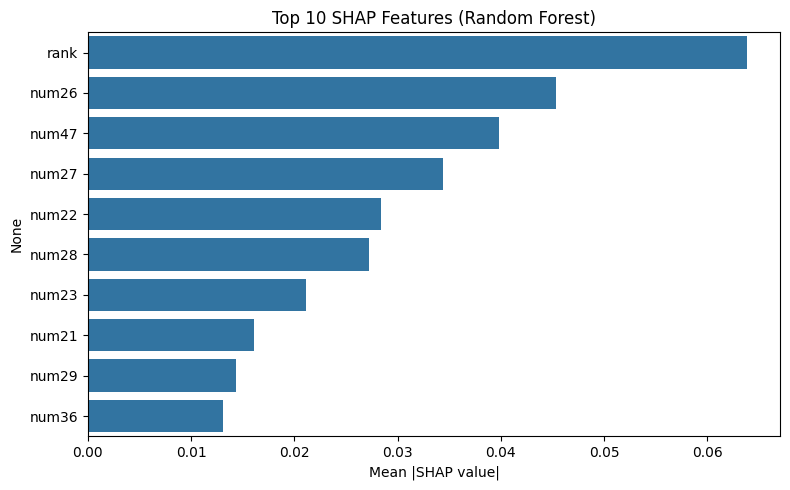


📊 Wichtigste Features laut SHAP (Random Forest):
rank     0.063850
num26    0.045327
num47    0.039870
num27    0.034442
num22    0.028415
num28    0.027213
num23    0.021149
num21    0.016049
num29    0.014322
num36    0.013132
dtype: float64


In [9]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 📁 Ensure output directory exists
os.makedirs("output", exist_ok=True)

# Initialize SHAP JavaScript visualizations
shap.initjs()

# 🌲 Create SHAP explainer for Random Forest
rf_shap_explainer = shap.TreeExplainer(rf)

# 📌 Use a sample of the test data to speed up SHAP calculation
X_rf_sample = X_test.sample(n=300, random_state=42)

# 📈 Compute SHAP values
rf_shap_values_raw = rf_shap_explainer.shap_values(X_rf_sample)

# 📉 Select SHAP values for class 1 (Click)
if isinstance(rf_shap_values_raw, list) and len(rf_shap_values_raw) == 2:
    rf_shap_values = rf_shap_values_raw[1]
else:
    rf_shap_values = rf_shap_values_raw

# 🧠 Reduce 3D SHAP values (samples, features, classes) to 2D if necessary
if isinstance(rf_shap_values, np.ndarray) and rf_shap_values.ndim == 3:
    rf_shap_values = rf_shap_values[:, :, 1]

# 🔍 SHAP Summary Plot
shap.summary_plot(rf_shap_values, X_rf_sample)

# 📊 Calculate Mean Absolute SHAP Importance
rf_shap_mean_abs = np.abs(rf_shap_values).mean(axis=0)
rf_shap_importance = pd.Series(rf_shap_mean_abs, index=X_rf_sample.columns).sort_values(ascending=False)

# 📉 Top 10 SHAP Features – Barplot
plt.figure(figsize=(8, 5))
sns.barplot(x=rf_shap_importance.head(10), y=rf_shap_importance.head(10).index)
plt.title("Top 10 SHAP Features (Random Forest)")
plt.xlabel("Mean |SHAP value|")
plt.tight_layout()
plt.savefig("output/shap_barplot_rf.png", bbox_inches="tight")
plt.show()

# 💾 Save SHAP values as CSV
rf_shap_df = pd.DataFrame(rf_shap_values, columns=X_rf_sample.columns)
rf_shap_df.to_csv("output/shap_values_rf.csv", index=False)

# 📝 Display Top Features in Console
print("\n📊 Wichtigste Features laut SHAP (Random Forest):")
print(rf_shap_importance.head(10))


## Lime Analysis

/home/codespace/.python/current/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/codespace/.python/current/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/codespace/.python/current/lib/python3.12/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wit


LIME Erklärung (Top Features):
rank <= 1.00: 0.0556
num26 > 0.24: 0.0468
cat0_2 <= 0.00: -0.0429
num27 > 0.24: 0.0383
num36 > -0.19: -0.0276
num47 > 0.30: 0.0230
num43 > -0.18: -0.0182
num33 > -0.19: -0.0176
num50 > 0.45: -0.0144
cat1_2 <= 0.00: 0.0106


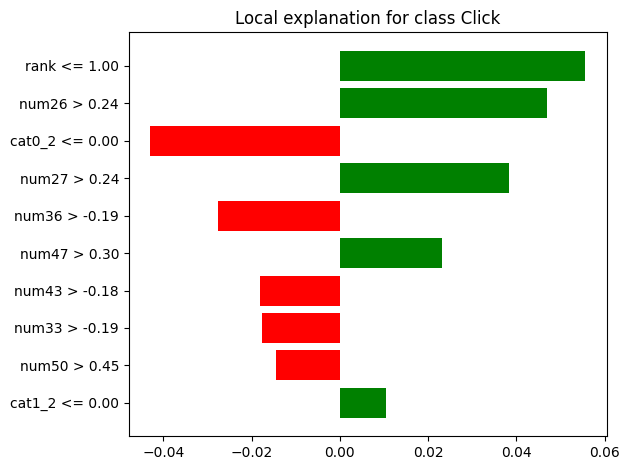

In [10]:
import lime
import lime.lime_tabular
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt

# 📌 Setup LIME Explainer for Random Forest
rf_lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['No Click', 'Click'],
    mode='classification',
    discretize_continuous=True
)

# 🧪 Choose instance to explain
sample_index = 0
rf_instance_to_explain = X_test.iloc[sample_index]

# 🔍 Compute LIME explanation
rf_lime_explanation = rf_lime_explainer.explain_instance(
    data_row=rf_instance_to_explain,
    predict_fn=rf.predict_proba,
    num_features=10
)

# 🖥️ Visualize explanation
display(HTML(rf_lime_explanation.as_html()))
print("\nLIME Erklärung (Top Features):")
for feature, weight in rf_lime_explanation.as_list():
    print(f"{feature}: {weight:.4f}")

# 📉 Barplot
fig = rf_lime_explanation.as_pyplot_figure()
fig.tight_layout()
plt.show()


## XGBoost Model
Now we will train the XGBoost Model


XGBoost


Confusion Matrix:
[[1160  338]
 [ 326 1172]]

Classification Report:
              precision    recall  f1-score   support

           0     0.7806    0.7744    0.7775      1498
           1     0.7762    0.7824    0.7793      1498

    accuracy                         0.7784      2996
   macro avg     0.7784    0.7784    0.7784      2996
weighted avg     0.7784    0.7784    0.7784      2996

ROC-AUC Score: 0.850315774838191
Accuracy: 0.7783711615487316


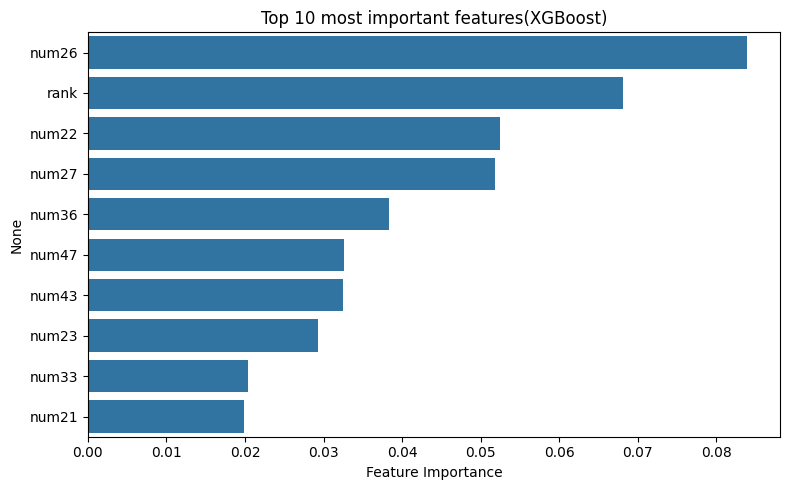

In [11]:
#%pip install xgboost
#%pip install pandas==2.0.3

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score
)
from sklearn.dummy import DummyClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*60)
print("XGBoost")
print("="*60)

# Set up XGBoost
xgb_model = xgb.XGBClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    eval_metric="logloss"
)

xgb_model.fit(X_train.values, y_train.values)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, digits=4))

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))

# Top 10 features
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_features, y=top_features.index)
plt.title("Top 10 most important features(XGBoost)")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

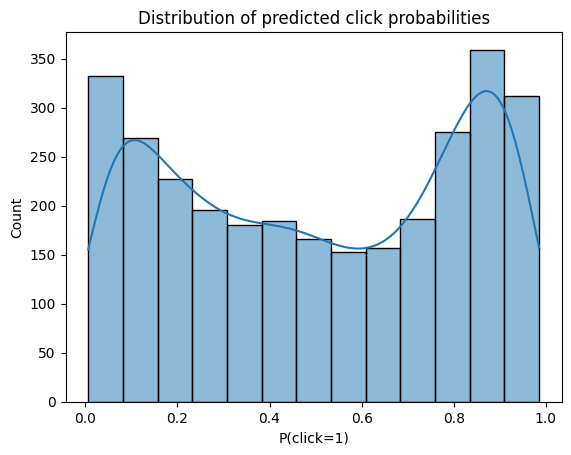

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

probaxg = xgb_model.predict_proba(X_test)[:, 1]
sns.histplot(probaxg, kde=True)
plt.title("Distribution of predicted click probabilities")
plt.xlabel("P(click=1)")
plt.show()


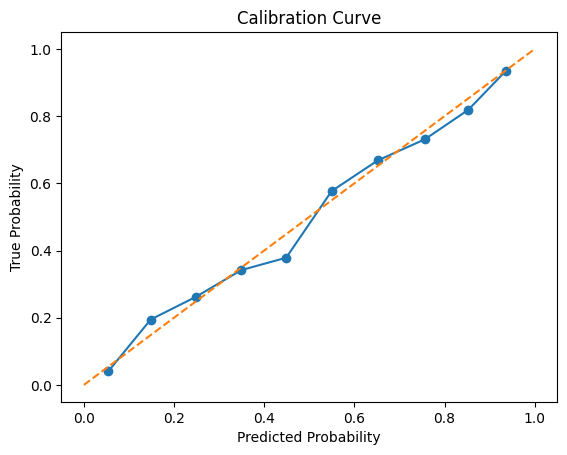

In [13]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, probaxg, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.show()


## Shap Analysis on XGBoost

In [14]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ⚙️ SHAP TreeExplainer für XGBoost
xgb_explainer = shap.TreeExplainer(xgb_classifier)

# 🔍 SHAP-Werte berechnen
xgb_shap_values = xgb_explainer.shap_values(X_test)

# 📊 SHAP Summary Plot
shap.summary_plot(xgb_shap_values, X_test)

# 🔝 SHAP Feature Importance berechnen
xgb_shap_abs = np.abs(xgb_shap_values).mean(axis=0)
xgb_shap_importance = pd.Series(xgb_shap_abs, index=X_test.columns).sort_values(ascending=False)

# 📈 Balkendiagramm der Top-10 Features
plt.figure(figsize=(8, 5))
xgb_shap_importance.head(10).plot(kind='barh')
plt.title("Top 10 SHAP Features (XGBoost)")
plt.xlabel("Mean |SHAP value|")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 🔍 Lokale SHAP-Erklärung für eine Instanz
i = 0
shap.plots.force(
    xgb_explainer.expected_value,
    xgb_shap_values[i],
    X_test.iloc[i]
)


NameError: name 'xgb_classifier' is not defined

# Lime Analysis for XGBoost


LIME Erklärung (Top Features):
[('rank <= 1.00', 0.18943169451553163), ('num27 > 0.24', 0.08686618079406246), ('num26 > 0.24', 0.08544088874249675), ('num36 > -0.19', -0.05907823443486177), ('num47 > 0.30', 0.054929266947388845), ('num18 <= -0.13', -0.05473125388982377), ('num44 > 0.50', -0.04578807589343625), ('cat0_2 <= 0.00', 0.04549338803959952), ('num43 > -0.18', -0.043153840938840116), ('cat1_2 <= 0.00', 0.03438588981436969)]


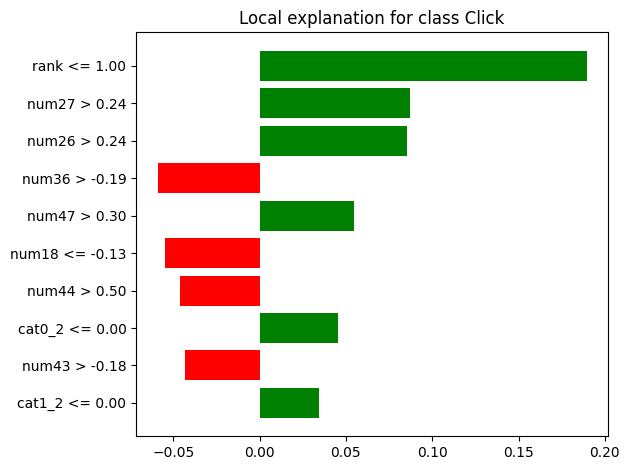

In [ ]:
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# 🧠 LIME-Explainer vorbereiten
xgb_lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=["No Click", "Click"],
    mode="classification"
)

i = 0
xgb_instance = X_test.iloc[i].values

# 📌 LIME-Erklärung erzeugen
lime_exp_result = xgb_lime_explainer.explain_instance(
    data_row=xgb_instance,
    predict_fn=xgb_model.predict_proba,
    num_features=10
)

# 💬 Ergebnis visualisieren
display(HTML(lime_exp_result.as_html()))
print("\nLIME Erklärung (Top Features):")
print(lime_exp_result.as_list())

fig = lime_exp_result.as_pyplot_figure()
fig.tight_layout()
plt.show()


# Metrics


In [16]:
from sklearn.metrics import average_precision_score, roc_auc_score
from scipy.stats import spearmanr
import numpy as np
import pandas as pd
import shap
import lime
import lime.lime_tabular

# AUPRC für Top K Features
def compute_auprc_topk_multi(y_true, shap_values, X, model, top_ks=[3, 5, 10]):
    if shap_values.ndim == 3:
        shap_vals_2d = shap_values[:, :, 1]
    else:
        shap_vals_2d = shap_values

    shap_importance = np.abs(shap_vals_2d).mean(axis=0)
    results = {}
    for k in top_ks:
        top_indices = np.argsort(shap_importance)[-k:]
        top_columns = X.columns[top_indices]

        X_masked = X.copy()
        X_masked[[col for col in X.columns if col not in top_columns]] = 0

        score = average_precision_score(y_true, model.predict_proba(X_masked)[:, 1])
        results[f"AUPRC_top{k}"] = round(score, 4)
    return results

# MEMC
def compute_memc(model, X, y, shap_values):
    if shap_values.ndim == 3:
        shap_vals_2d = shap_values[:, :, 1]
    else:
        shap_vals_2d = shap_values

    shap_importance = np.abs(shap_vals_2d).mean(axis=0)
    top_indices = np.argsort(shap_importance)[::-1]
    top_cols = X.columns[top_indices]
    removal_sets = [top_cols[:k].tolist() for k in [1, 3, 5]]

    base_auc = roc_auc_score(y, model.predict_proba(X)[:, 1])
    drops = []
    for cols in removal_sets:
        X_mut = X.copy()
        X_mut[cols] = 0
        auc = roc_auc_score(y, model.predict_proba(X_mut)[:, 1])
        drops.append(base_auc - auc)
    return np.mean(drops)

# Infidelity
def compute_infidelity(model, X, shap_values, eps=1e-2):
    try:
        if shap_values.ndim == 3:
            shap_vals_2d = shap_values[:, :, 1]
        else:
            shap_vals_2d = shap_values

        noise = np.random.normal(0, eps, size=X.shape)
        X_noise = X.copy()
        X_noise.iloc[:, :] = X.values + noise

        pred_diff = model.predict_proba(X)[:, 1] - model.predict_proba(X_noise)[:, 1]
        explanation_diff = (shap_vals_2d * noise).sum(axis=1)
        return np.mean((pred_diff - explanation_diff) ** 2)
    except Exception:
        return np.nan

# Sensitivity
def compute_sensitivity(model, X, shap_values, eps=1e-2):
    try:
        if shap_values.ndim == 3:
            shap_vals_2d = shap_values[:, :, 1]
        else:
            shap_vals_2d = shap_values

        noise = np.random.normal(0, eps, size=X.shape)
        X_pert = X.copy()
        X_pert.iloc[:, :] = X.values + noise

        shap_vals_pert = shap.TreeExplainer(model).shap_values(X_pert)
        if isinstance(shap_vals_pert, list):
            shap_vals_pert = shap_vals_pert[1]
        elif shap_vals_pert.ndim == 3:
            shap_vals_pert = shap_vals_pert[:, :, 1]

        return np.mean(np.abs(shap_vals_pert - shap_vals_2d))
    except Exception:
        return np.nan

# Monotonicity
def compute_monotonicity(shap_values, X):
    try:
        if shap_values.ndim == 3:
            shap_vals_2d = shap_values[:, :, 1]
        else:
            shap_vals_2d = shap_values

        total, valid = 0, 0
        for i, col in enumerate(X.columns):
            if i < shap_vals_2d.shape[1] and X[col].std() > 0:
                corr = np.corrcoef(X[col], shap_vals_2d[:, i])[0, 1]
                if not np.isnan(corr):
                    valid += 1
                    if corr >= 0:
                        total += 1
        return total / valid if valid > 0 else 0
    except Exception:
        return np.nan

# Hauptfunktion
def evaluate_model_explainability_updated(model, model_name, X_train, X_test, y_test):
    try:
        X_sample = X_test.sample(n=min(300, len(X_test)), random_state=42)
        y_sample = y_test.loc[X_sample.index]

        shap_vals = shap.TreeExplainer(model).shap_values(X_sample)
        if isinstance(shap_vals, list):
            shap_vals = shap_vals[1]
        elif shap_vals.ndim == 3:
            shap_vals = shap_vals[:, :, 1]

        explainer_lime = lime.lime_tabular.LimeTabularExplainer(
            training_data=X_train.values,
            feature_names=X_train.columns.tolist(),
            class_names=["No Click", "Click"],
            mode="classification",
            discretize_continuous=True
        )
        instance = X_sample.iloc[0]
        lime_expl = explainer_lime.explain_instance(
            instance.values,
            model.predict_proba,
            num_features=len(X_sample.columns)
        )
        lime_map = lime_expl.as_map()[1]
        lime_vector = np.zeros(X_sample.shape[1])
        for fid, weight in lime_map:
            lime_vector[fid] = weight

        shap_vector = np.abs(shap_vals[0])
        corr = spearmanr(lime_vector, shap_vector).correlation if lime_vector.shape == shap_vector.shape else np.nan

        metrics = {
            "Model": model_name,
            "MEMC": round(compute_memc(model, X_sample, y_sample, shap_vals), 4),
            **compute_auprc_topk_multi(y_sample, shap_vals, X_sample, model, top_ks=[3, 5, 10]),
            "ρ(LIME, SHAP)": round(corr, 4) if not np.isnan(corr) else np.nan,
            "Infidelity": round(compute_infidelity(model, X_sample, shap_vals), 4),
            "Sensitivity": round(compute_sensitivity(model, X_sample, shap_vals), 4),
            "Monotonicity": round(compute_monotonicity(shap_vals, X_sample), 4)
        }
        return metrics
    except Exception:
        return {
            "Model": model_name, "MEMC": np.nan, "AUPRC_top3": np.nan,
            "AUPRC_top5": np.nan, "AUPRC_top10": np.nan, "ρ(LIME, SHAP)": np.nan,
            "Infidelity": np.nan, "Sensitivity": np.nan, "Monotonicity": np.nan
        }

# Create Evaluation Table
rf_metrics = evaluate_model_explainability_updated(rf, "Random Forest", X_train, X_test, y_test)
xgb_metrics = evaluate_model_explainability_updated(xgb_model, "XGBoost", X_train, X_test, y_test)

results_df = pd.DataFrame([rf_metrics, xgb_metrics])
results_df



/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/tmp/ipykernel_17173/2506037993.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[8.993999182369311, 13.006642753075875, 1.019510870181832, 3.0082102002732, 1.9922253665451988, 2.011479880257231, 10.003258633023007, 3.0032341233833355, 5.0014902028841846, 1.008565208410779, 14.007045536316651, 1.9967987564738199, 2.9961749899545143, 2.9862967303781818, 4.007514586680288, 4.000663171318118, 10.0049813464154, 0.9988684598807315, 10.001228916683974, 1.0021647454534723, 3.019941427500169, 0.999410179539177, 3.007292117513546, 1.0027304346913608, 6.99978514510371, 7.01160611411864, 8.002323801543865, 7.987848382686345, 10.995914154530507, 3.0098755513998454, 5.997375865619009, 12.994929234602086, 0.99554718999

Model    MEMC  AUPRC_top3  AUPRC_top5  AUPRC_top10  ρ(LIME, SHAP)  \
0  Random Forest  0.1143      0.7522      0.7468       0.7393        -0.7222   
1        XGBoost  0.1366      0.8029      0.8016       0.8339        -0.4450   

   Infidelity  Sensitivity  Monotonicity  
0      0.0025       0.0015        0.4545  
1      0.0056       0.0108        0.4921

## Explanation

### MEMC
The MEMC value shows how much the ML outcome would be influenced in case the most influential features according to SHAP were removed.  
The MEMC value is higher in **XGBoost**, which is reasonable as the **RF model is more robust and cautious**. The SHAP values for RF range between approximately **-0.15 and 0.15**, while XGBoost shows a much wider SHAP range (up to **±2.5**), indicating stronger feature effects and thus a higher MEMC.

### AUPRC
The AUPRC values (`top 3`, `5`, and `10` features) reflect the model’s ability to retain predictive performance using only the most important features.  
**XGBoost performs better** across all `AUPRC_topK` scores, suggesting it relies more consistently on a small number of highly influential features. This indicates a **sharper feature importance distribution** compared to RF, where the contribution is more evenly spread across features.

### ρ(LIME, SHAP)
The Spearman correlation between LIME and SHAP explanations is **negative** for both models, particularly for Random Forest (**-0.7222**), indicating a **disagreement** between the two explanation methods.  
This may stem from the fact that SHAP uses tree-based logic aligned with the model internals, while LIME fits a **local surrogate model** that may misrepresent the global structure, especially in models like RF with high variance between trees.

### Infidelity
**Infidelity is lower** for Random Forest (**0.0025**), indicating that the SHAP explanations **better approximate the model’s behavior** when inputs are slightly perturbed.  
This is consistent with RF being more stable and interpretable than XGBoost.

### Sensitivity
**Sensitivity is lower** in RF (**0.0015**), meaning explanations remain more stable when input data is slightly changed.  
This aligns with expectations: **XGBoost**, while more powerful, is **more sensitive to small changes** due to its gradient boosting structure.

### Monotonicity
**Monotonicity** is slightly higher for **XGBoost** (**0.4921** vs. **0.4545**), showing that for nearly half of the features, a higher input value correlates with a higher SHAP value.  
This suggests more consistent directional relationships between features and predictions in XGBoost than in Random Forest.
